In [24]:
import pandas as pd
election_data = pd.read_csv("countypres_2000-2020.csv")

# Inspecting columns and cleaning the Election Data
election_data_cleaned = election_data[
    ['year', 'state', 'state_po', 'county_name', 'county_fips', 'candidate', 
     'party', 'candidatevotes', 'totalvotes']
].dropna()

# Renaming columns for clarity and consistency
election_data_cleaned = election_data_cleaned.rename(columns={
    'state_po': 'state_abbreviation',
    'county_fips': 'fips_code',
    'candidatevotes': 'votes_candidate',
    'totalvotes': 'votes_total'
})

# Displaying the first few rows of the cleaned dataset
election_data_cleaned

,year,state,state_abbreviation,county_name,fips_code,candidate,party,votes_candidate,votes_total
0,2000,ALABAMA,AL,AUTAUGA,1001.0,AL GORE,DEMOCRAT,4942,17208
1,2000,ALABAMA,AL,AUTAUGA,1001.0,GEORGE W. BUSH,REPUBLICAN,11993,17208
2,2000,ALABAMA,AL,AUTAUGA,1001.0,RALPH NADER,GREEN,160,17208
3,2000,ALABAMA,AL,AUTAUGA,1001.0,OTHER,OTHER,113,17208
4,2000,ALABAMA,AL,BALDWIN,1003.0,AL GORE,DEMOCRAT,13997,56480
...,...,...,...,...,...,...,...,...,...
72612,2020,WYOMING,WY,WASHAKIE,56043.0,DONALD J TRUMP,REPUBLICAN,3245,4032
72613,2020,WYOMING,WY,WESTON,56045.0,JOSEPH R BIDEN JR,DEMOCRAT,360,3560
72614,2020,WYOMING,WY,WESTON,56045.0,JO JORGENSEN,LIBERTARIAN,46,3560
72615,2020,WYOMING,WY,WESTON,56045.0,OTHER,OTHER,47,3560


In [25]:
# Analyzing election results for each county in each election year

# Group data by year, state, county, and party to calculate total votes by party
county_election_results = election_data_cleaned.groupby(
    ['year', 'state', 'county_name', 'party']
).agg({'votes_candidate': 'sum'}).reset_index()

# Find the winning party for each county in each year
county_election_results['rank'] = county_election_results.groupby(
    ['year', 'state', 'county_name']
)['votes_candidate'].rank(method='max', ascending=False)

# Filter to get only the winning party for each county-year
winning_party_per_county = county_election_results[county_election_results['rank'] == 1].drop(columns=['rank'])

# Sort results for better readability
winning_party_per_county = winning_party_per_county.sort_values(by=['year', 'state', 'county_name'])

winning_party_per_county

,year,state,county_name,party,votes_candidate
3,2000,ALABAMA,AUTAUGA,REPUBLICAN,11993
7,2000,ALABAMA,BALDWIN,REPUBLICAN,40872
8,2000,ALABAMA,BARBOUR,DEMOCRAT,5188
15,2000,ALABAMA,BIBB,REPUBLICAN,4273
19,2000,ALABAMA,BLOUNT,REPUBLICAN,12667
...,...,...,...,...,...
64031,2020,WYOMING,SWEETWATER,REPUBLICAN,12229
64032,2020,WYOMING,TETON,DEMOCRAT,9848
64039,2020,WYOMING,UINTA,REPUBLICAN,7496
64043,2020,WYOMING,WASHAKIE,REPUBLICAN,3245


In [26]:
# Identifying swing counties (counties that changed their winning party between elections)

# Create a DataFrame of winning parties by year, state, and county
winning_party_pivot = winning_party_per_county.pivot_table(
    index=['state', 'county_name'], 
    columns='year', 
    values='party', 
    aggfunc='first'
).reset_index()

# Identify swing counties (counties with more than one unique winning party)
winning_party_pivot['unique_parties'] = winning_party_pivot.iloc[:, 2:].nunique(axis=1)
swing_counties = winning_party_pivot[winning_party_pivot['unique_parties'] > 1]

# Identify consistent counties (counties with the same winning party across all elections)
consistent_counties = winning_party_pivot[winning_party_pivot['unique_parties'] == 1]

# Drop the helper column `unique_parties` for presentation
swing_counties = swing_counties.drop(columns=['unique_parties'])
consistent_counties = consistent_counties.drop(columns=['unique_parties'])
swing_counties, consistent_counties

(year      state county_name        2000        2004        2008        2012  \
 2       ALABAMA     BARBOUR    DEMOCRAT  REPUBLICAN  REPUBLICAN    DEMOCRAT   
 11      ALABAMA     CHOCTAW    DEMOCRAT  REPUBLICAN  REPUBLICAN  REPUBLICAN   
 16      ALABAMA     COLBERT    DEMOCRAT  REPUBLICAN  REPUBLICAN  REPUBLICAN   
 17      ALABAMA     CONECUH    DEMOCRAT  REPUBLICAN  REPUBLICAN    DEMOCRAT   
 35      ALABAMA     JACKSON    DEMOCRAT  REPUBLICAN  REPUBLICAN  REPUBLICAN   
 ...         ...         ...         ...         ...         ...         ...   
 3164  WISCONSIN    WAUSHARA  REPUBLICAN  REPUBLICAN    DEMOCRAT  REPUBLICAN   
 3165  WISCONSIN   WINNEBAGO  REPUBLICAN  REPUBLICAN    DEMOCRAT    DEMOCRAT   
 3166  WISCONSIN        WOOD  REPUBLICAN  REPUBLICAN    DEMOCRAT  REPUBLICAN   
 3167    WYOMING      ALBANY  REPUBLICAN  REPUBLICAN    DEMOCRAT  REPUBLICAN   
 3186    WYOMING       TETON  REPUBLICAN    DEMOCRAT    DEMOCRAT    DEMOCRAT   
 
 year        2016        2020  
 2    

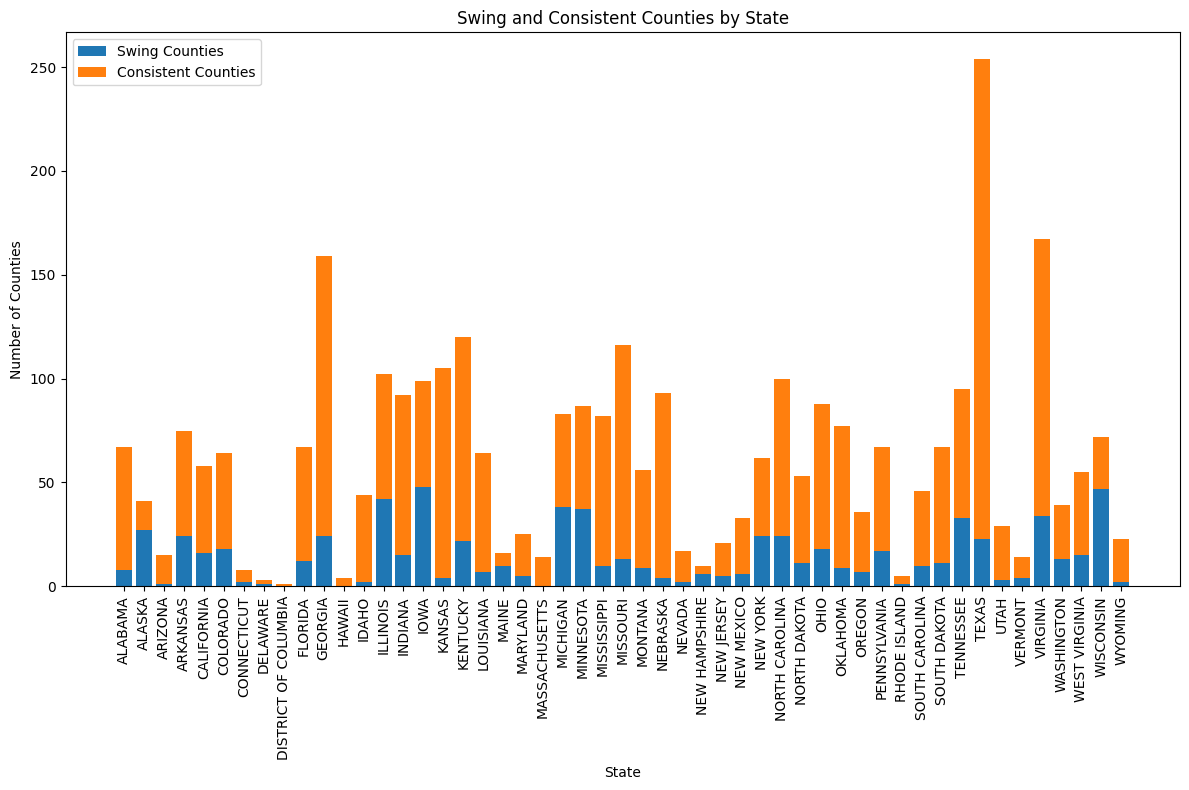

In [27]:
#visualizing the swing counties and consistent counties per by state

import matplotlib.pyplot as plt

# Count the number of swing and consistent counties per state
swing_counts_by_state = swing_counties.groupby('state').size().reset_index(name='swing_counties')
consistent_counts_by_state = consistent_counties.groupby('state').size().reset_index(name='consistent_counties')

# Merge the counts for visualization
state_counts = pd.merge(swing_counts_by_state, consistent_counts_by_state, on='state', how='outer').fillna(0)

# Visualization of swing and consistent counties by state
plt.figure(figsize=(12, 8))

# Bar chart for swing counties
plt.bar(state_counts['state'], state_counts['swing_counties'], label='Swing Counties')

# Bar chart for consistent counties stacked on top
plt.bar(state_counts['state'], state_counts['consistent_counties'], bottom=state_counts['swing_counties'], label='Consistent Counties')

# Add chart details
plt.xlabel('State')
plt.ylabel('Number of Counties')
plt.title('Swing and Consistent Counties by State')
plt.xticks(rotation=90)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [28]:
import csv

unemployment_data = pd.read_csv("Unemployment(UnemploymentMedianIncome).csv")
list_of_column_names = []

with open('Unemployment(UnemploymentMedianIncome).csv') as csv_file:
 
    csv_reader = csv.DictReader(csv_file)
 
    dict_from_csv = dict(list(csv_reader)[0])
 
    list_of_column_names = list(dict_from_csv.keys())
 

unemployment_data_cleaned = unemployment_data[list_of_column_names].dropna()

columns = []
for i in range(0,22):
    new_str = 'employed_' + str(2000 + i)
    new_str2 = 'unemployed_' + str(2000 + i)
    new_str3 = 'unemployment_rate_' + str(2000 + i)
    columns.append(new_str)
    columns.append(new_str2)
    columns.append(new_str3)

new_columns = [
    "fips_code", "state", "county_name", 
    "rural_code", "urban_code", 
    "metro", "civilian_labor_force"
]
new_columns.append(columns)
                   

# Remove specified columns
columns_to_remove = [
    'Rural_Urban_Continuum_Code_2013',
    'Urban_Influence_Code_2013',
    'Metro_2013',
    'Median_Household_Income_2021',
    'Med_HH_Income_Percent_of_State_Total_2021'
]
unemployment_data_cleaned = unemployment_data_cleaned.drop(columns=columns_to_remove, errors='ignore')
unemployment_data_cleaned

,FIPS_Code,State,Area_Name,Civilian_labor_force_2000,Employed_2000,Unemployed_2000,Unemployment_rate_2000,Civilian_labor_force_2001,Employed_2001,Unemployed_2001,...,Unemployed_2020,Unemployment_rate_2020,Civilian_labor_force_2021,Employed_2021,Unemployed_2021,Unemployment_rate_2021,Civilian_labor_force_2022,Employed_2022,Unemployed_2022,Unemployment_rate_2022
2,1001,AL,"Autauga County, AL","21,861","20,971",890,4.1,"22,081","21,166",915,...,"1,402",5.3,"26,545","25,809",736,2.8,"26,789","26,181",608,2.3
3,1003,AL,"Baldwin County, AL","69,979","67,370","2,609",3.7,"69,569","66,545","3,024",...,"6,086",6.1,"99,953","97,034","2,919",2.9,"102,849","100,432","2,417",2.4
4,1005,AL,"Barbour County, AL","11,449","10,812",637,5.6,"11,324","10,468",856,...,667,7.7,"8,280","7,821",459,5.5,"8,241","7,906",335,4.1
5,1007,AL,"Bibb County, AL","8,623","8,160",463,5.4,"9,134","8,513",621,...,632,7.3,"8,641","8,347",294,3.4,"8,726","8,507",219,2.5
6,1009,AL,"Blount County, AL","25,266","24,375",891,3.5,"25,450","24,521",929,...,"1,126",4.5,"25,377","24,779",598,2.4,"25,796","25,222",574,2.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193,56037,WY,"Sweetwater County, WY","20,623","19,822",801,3.9,"20,770","19,962",808,...,"1,529",7.5,"19,354","18,243","1,111",5.7,"19,507","18,696",811,4.2
3194,56039,WY,"Teton County, WY","14,126","13,791",335,2.4,"14,184","13,812",372,...,901,6.0,"15,906","15,375",531,3.3,"16,647","16,193",454,2.7
3195,56041,WY,"Uinta County, WY","10,414","10,004",410,3.9,"10,739","10,339",400,...,580,6.4,"8,812","8,355",457,5.2,"8,863","8,524",339,3.8
3196,56043,WY,"Washakie County, WY","4,287","4,093",194,4.5,"4,206","4,024",182,...,208,5.3,"3,939","3,776",163,4.1,"3,858","3,704",154,4.0


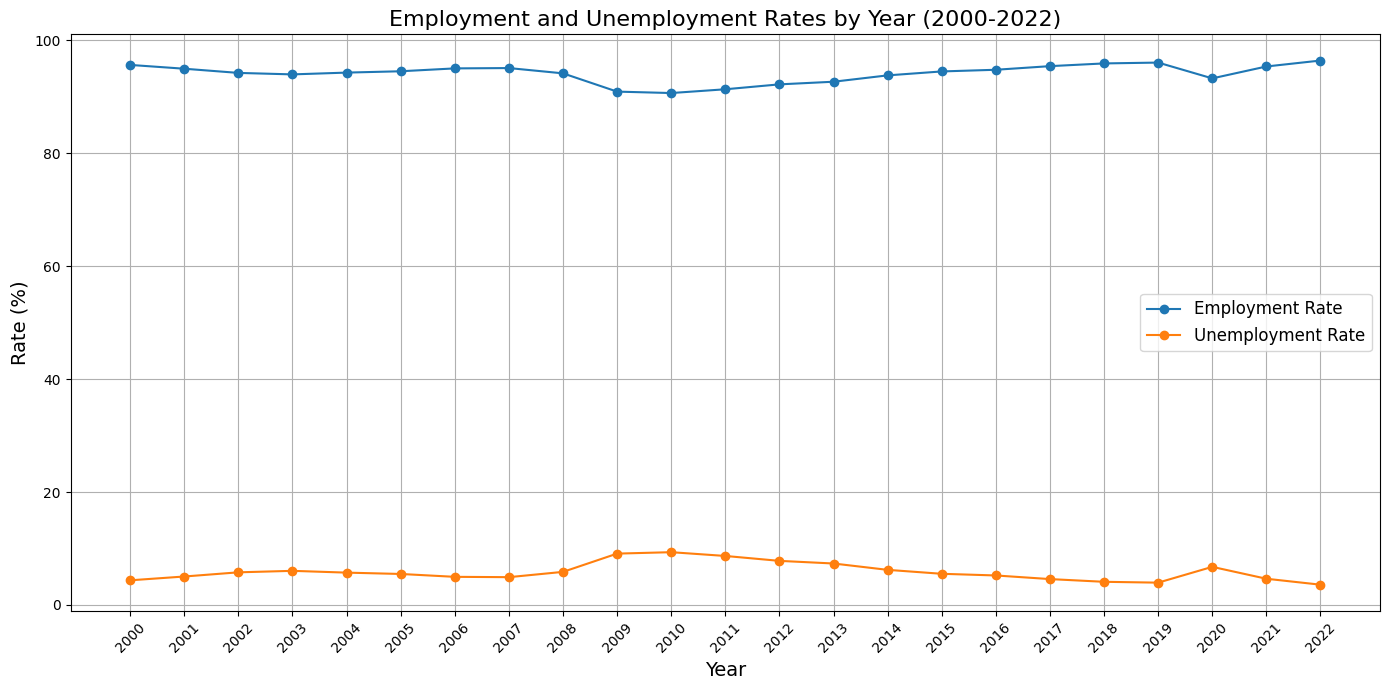

In [29]:
years = list(range(2000, 2023))  # Years from 2000 to 2022
employment_rates = []
unemployment_rates = []

for year in years:
    # Define column names based on the year
    employed_col = f'Employed_{year}'
    unemployed_col = f'Unemployed_{year}'
    unemployment_rate_col = f'Unemployment_rate_{year}'
    
    # Check if all required columns exist for the year
    if all(col in unemployment_data_cleaned.columns for col in [employed_col, unemployed_col, unemployment_rate_col]):
        # Calculate the average unemployment rate for the year
        avg_unemployment_rate = unemployment_data_cleaned[unemployment_rate_col].mean()
        unemployment_rates.append(avg_unemployment_rate)
        
        # Calculate the average employment rate as 100 - Unemployment Rate
        avg_employment_rate = 100 - avg_unemployment_rate
        employment_rates.append(avg_employment_rate)
    else:
        # If any column is missing, append None (will handle later)
        unemployment_rates.append(None)
        employment_rates.append(None)

# Create a DataFrame to hold the rates
rates_df = pd.DataFrame({
    'Year': years,
    'Employment Rate (%)': employment_rates,
    'Unemployment Rate (%)': unemployment_rates
})

# Remove any years with missing data
rates_df = rates_df.dropna()

# Step 4: Plot the Employment and Unemployment Rates by Year
plt.figure(figsize=(14, 7))
plt.plot(rates_df['Year'], rates_df['Employment Rate (%)'], marker='o', label='Employment Rate')
plt.plot(rates_df['Year'], rates_df['Unemployment Rate (%)'], marker='o', label='Unemployment Rate')

# Customize the plot
plt.title('Employment and Unemployment Rates by Year (2000-2022)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Rate (%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(rates_df['Year'], rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Display the plot
plt.show()

In [30]:
import pandas as pd

# File paths
file_2000_2010 = 'population-2000-2010.csv'
file_2010_2020 = 'population-2010-2020.csv'
file_2020_2023 = 'population-2020-2023.csv'

# Read the CSV files
pop_2000_2010 = pd.read_csv(file_2000_2010, encoding='ISO-8859-1')
pop_2010_2020 = pd.read_csv(file_2010_2020, encoding='ISO-8859-1')
pop_2020_2023 = pd.read_csv(file_2020_2023, encoding='ISO-8859-1')

# Define columns to keep for each time range
columns_to_keep_2000 = ['STATE', 'COUNTY', 'STNAME'] + [f'POPESTIMATE{year}' for year in range(2000, 2011)]
columns_to_keep_2010 = ['STATE', 'COUNTY', 'STNAME'] + [f'POPESTIMATE{year}' for year in range(2011, 2021)]  # Exclude 2010
columns_to_keep_2020 = ['STATE', 'COUNTY', 'STNAME'] + [f'POPESTIMATE{year}' for year in range(2021, 2023)]  # Exclude 2020

# Filter the columns for each dataset
pop_2000_2010_filtered = pop_2000_2010[columns_to_keep_2000]
pop_2010_2020_filtered = pop_2010_2020[columns_to_keep_2010]
pop_2020_2023_filtered = pop_2020_2023[columns_to_keep_2020]

# Reset index before merging
pop_2000_2010_filtered = pop_2000_2010_filtered.reset_index(drop=True)
pop_2010_2020_filtered = pop_2010_2020_filtered.reset_index(drop=True)
pop_2020_2023_filtered = pop_2020_2023_filtered.reset_index(drop=True)

# Merge 2000-2010 with 2010-2020
combined_df = pd.merge(
    pop_2000_2010_filtered,
    pop_2010_2020_filtered,
    on=['STATE', 'COUNTY', 'STNAME'],
    how='inner'  # Change to 'outer' if you want to retain all rows
)

# Merge the above result with 2020-2023
combined_df = pd.merge(
    combined_df,
    pop_2020_2023_filtered,
    on=['STATE', 'COUNTY', 'STNAME'],
    how='inner'  # Change to 'outer' if you want to retain all rows
)

# Filter out rows where COUNTY is 0
combined_df = combined_df[combined_df['COUNTY'] != 0]

# Add a new column for the FIPS code
combined_df['FIPS'] = combined_df['STATE'].astype(str).str.zfill(1) + combined_df['COUNTY'].astype(str).str.zfill(3)

# Reset the index after filtering
combined_df = combined_df.reset_index(drop=True)

# Optional: Sort the DataFrame by STATE and COUNTY
combined_df = combined_df.sort_values(by=['STATE', 'COUNTY']).reset_index(drop=True)

# Save the updated DataFrame as a CSV file
output_file_fips = 'combined_population_with_fips.csv'
combined_df.to_csv(output_file_fips, index=False, encoding='utf-8')

print(f"Filtered DataFrame with FIPS codes saved as {output_file_fips}")
combined_df

Filtered DataFrame with FIPS codes saved as combined_population_with_fips.csv


,STATE,COUNTY,STNAME,POPESTIMATE2000,POPESTIMATE2001,POPESTIMATE2002,POPESTIMATE2003,POPESTIMATE2004,POPESTIMATE2005,POPESTIMATE2006,...,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,FIPS
0,1,1,Alabama,44021,44889,45909,46800,48366,49676,51328,...,54922,54903,55302,55448,55533,55769,56145,59203,59726,1001
1,1,3,Alabama,141342,144875,147957,151509,156266,162183,168121,...,199306,203101,207787,212737,218071,223565,229287,239439,246531,1003
2,1,5,Alabama,29015,28863,28653,28594,28287,28027,27861,...,26768,26300,25828,25169,24887,24657,24589,24533,24700,1005
3,1,7,Alabama,19913,21028,21199,21399,21721,22042,22099,...,22541,22553,22590,22532,22300,22313,22136,22359,21986,1007
4,1,9,Alabama,51107,51845,52551,53457,54124,54624,55485,...,57536,57535,57487,57801,57770,57840,57879,59079,59516,1009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3126,56,37,Wyoming,37552,36899,37428,37450,38026,38739,39749,...,44996,44780,44319,43663,43188,42917,42673,41626,41374,56037
3127,56,39,Wyoming,18381,18653,18837,19066,19467,19632,20014,...,22801,23083,23255,23383,23261,23385,23497,23605,23297,56039
3128,56,41,Wyoming,19666,19413,19587,19480,19470,19494,19709,...,20835,20777,20711,20449,20299,20196,20215,20681,20727,56041
3129,56,43,Wyoming,8252,8068,7988,7976,7960,8022,7979,...,8277,8282,8180,8013,7886,7824,7760,7719,7724,56043


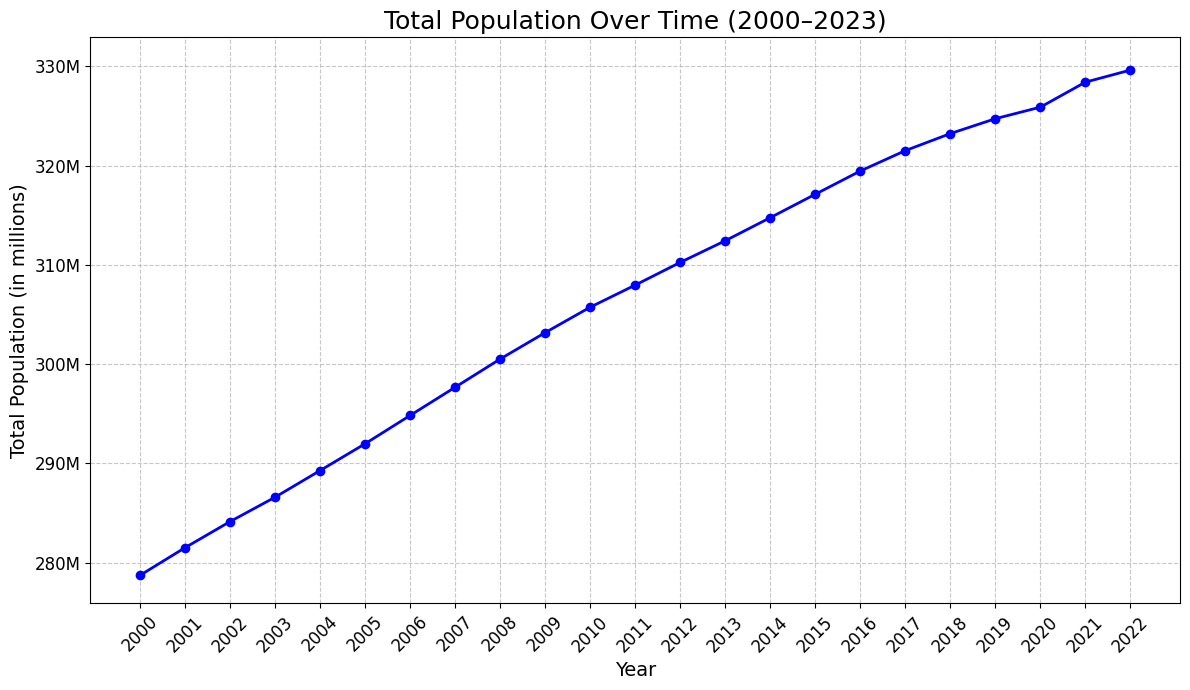

In [31]:
population_columns = [col for col in combined_df.columns if col.startswith('POPESTIMATE')]
years = [int(col[-4:]) for col in population_columns]

# Summing population across all rows for each year
population_totals = combined_df[population_columns].sum()

overall_population = pd.DataFrame({
    'Year': years,
    'Population': population_totals.values
})

# Plot the overall population trend with improved clarity
plt.figure(figsize=(12, 7))
plt.plot(overall_population['Year'], overall_population['Population'], marker='o', linestyle='-', linewidth=2, color='blue')
plt.title('Total Population Over Time (2000–2023)', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Population (in millions)', fontsize=14)

# Format y-axis ticks to show numbers in millions
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))

# Set y-axis limits (optional, to focus on the range of population values)
plt.ylim([overall_population['Population'].min()*0.99, overall_population['Population'].max()*1.01])

# Format x-axis to show every year clearly
plt.xticks(overall_population['Year'], rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [32]:
file_path = "Education.xlsx"
# Headers start at row 4 (0-based indexing: header=3)
education_df = pd.read_excel(file_path, engine='openpyxl', header=3)

# Rename columns
education_df = education_df.rename(columns={
    'FIPS Code': 'fips_code',
    'State': 'state',
    'Area name': 'county_name'
})

# Convert fips_code to numeric
education_df['fips_code'] = pd.to_numeric(education_df['fips_code'], errors='coerce')

# Remove " County" suffix if present
education_df['county_name'] = education_df['county_name'].astype(str).str.replace(' County', '', regex=False)

print("Education Data Cleaned (first 5 rows):")
education_df = education_df.dropna()
education_df

Education Data Cleaned (first 5 rows):


,fips_code,state,county_name,2003 Urban Influence Code,2013 Urban Influence Code,2013 Rural-urban Continuum Code,2023 Rural-urban Continuum Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,"Percent of adults completing some college or associate's degree, 2008-12","Percent of adults with a bachelor's degree or higher, 2008-12","Less than a high school diploma, 2018-22","High school diploma only, 2018-22","Some college or associate's degree, 2018-22","Bachelor's degree or higher, 2018-22","Percent of adults with less than a high school diploma, 2018-22","Percent of adults with a high school diploma only, 2018-22","Percent of adults completing some college or associate's degree, 2018-22","Percent of adults with a bachelor's degree or higher, 2018-22"
2,1001,AL,Autauga,2.0,2.0,2.0,2.0,6611.0,3757.0,933.0,...,29.618142,21.707831,3857.0,12517.0,11935.0,11879.0,9.597392,31.146113,29.697920,29.558575
3,1003,AL,Baldwin,5.0,2.0,3.0,3.0,18726.0,8426.0,2334.0,...,31.819503,27.741591,14031.0,46391.0,52215.0,54385.0,8.400690,27.775383,31.262349,32.561579
4,1005,AL,Barbour,6.0,6.0,6.0,6.0,8120.0,2242.0,581.0,...,25.771784,14.524286,4155.0,6507.0,4913.0,2100.0,23.507779,36.814710,27.796322,11.881188
5,1007,AL,Bibb,1.0,1.0,1.0,1.0,5272.0,1402.0,238.0,...,25.538085,8.996005,3366.0,6510.0,4310.0,1739.0,21.136578,40.879121,27.064364,10.919937
6,1009,AL,Blount,1.0,1.0,1.0,1.0,10677.0,3440.0,626.0,...,27.124512,12.381469,7447.0,14414.0,12939.0,6017.0,18.244849,35.313717,31.700027,14.741407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3210,56037,WY,Sweetwater,8.0,8.0,5.0,5.0,4393.0,3731.0,986.0,...,37.275232,17.006235,1919.0,9010.0,11151.0,5514.0,6.954410,32.652026,40.410959,19.982605
3211,56039,WY,Teton,8.0,8.0,7.0,7.0,708.0,908.0,524.0,...,23.332485,48.994399,721.0,2976.0,3400.0,10776.0,4.034018,16.650814,19.023107,60.292061
3212,56041,WY,Uinta,8.0,8.0,7.0,7.0,1569.0,1517.0,445.0,...,35.045548,18.272985,748.0,4821.0,5169.0,2536.0,5.635076,36.319120,38.940786,19.105017
3213,56043,WY,Washakie,11.0,11.0,7.0,9.0,1572.0,1437.0,590.0,...,35.062865,23.339826,292.0,1571.0,2491.0,1167.0,5.288897,28.454990,45.118638,21.137475


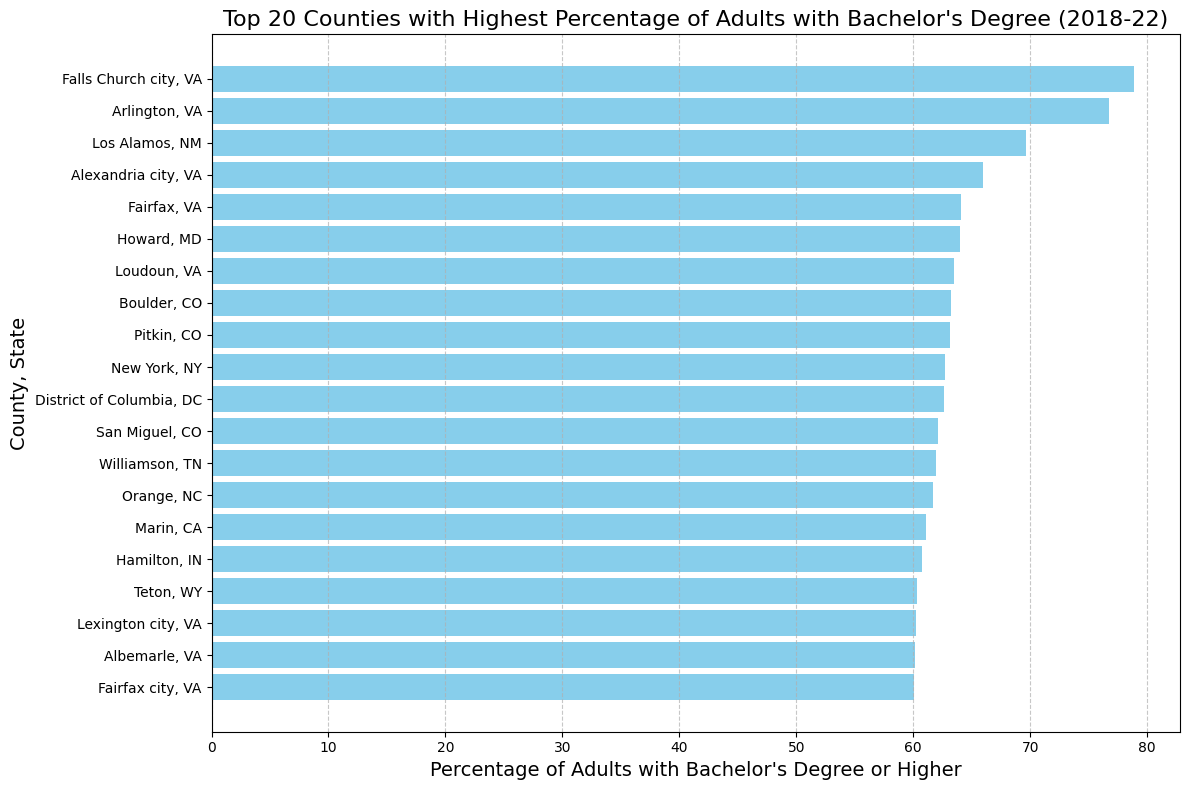

In [33]:
bachelor_col = "Percent of adults with a bachelor's degree or higher, 2018-22"
plot_data = education_df[['county_name', 'state', bachelor_col]]

# Sort by percentage for visualization
plot_data = plot_data.sort_values(by=bachelor_col, ascending=False).head(20)  # Top 20 counties

# Create a bar plot
plt.figure(figsize=(12, 8))
plt.barh(plot_data['county_name'] + ', ' + plot_data['state'], plot_data[bachelor_col], color='skyblue')
plt.title("Top 20 Counties with Highest Percentage of Adults with Bachelor's Degree (2018-22)", fontsize=16)
plt.xlabel("Percentage of Adults with Bachelor's Degree or Higher", fontsize=14)
plt.ylabel("County, State", fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Missing FIPS in election_data_cleaned: 0
Missing FIPS in unemployment_data_cleaned: 0
Missing FIPS in combined_df: 0
Merged DataFrame shape: (71403, 16)
   year    state state_abbreviation county_name       candidate       party  \
0  2000  ALABAMA                 AL     AUTAUGA         AL GORE    DEMOCRAT   
1  2000  ALABAMA                 AL     AUTAUGA  GEORGE W. BUSH  REPUBLICAN   
2  2000  ALABAMA                 AL     AUTAUGA     RALPH NADER       GREEN   
3  2000  ALABAMA                 AL     AUTAUGA           OTHER       OTHER   
4  2000  ALABAMA                 AL     BALDWIN         AL GORE    DEMOCRAT   

   votes_candidate  votes_total   FIPS State           Area_Name  \
0             4942        17208  01001    AL  Autauga County, AL   
1            11993        17208  01001    AL  Autauga County, AL   
2              160        17208  01001    AL  Autauga County, AL   
3              113        17208  01001    AL  Autauga County, AL   
4            13997        56480 

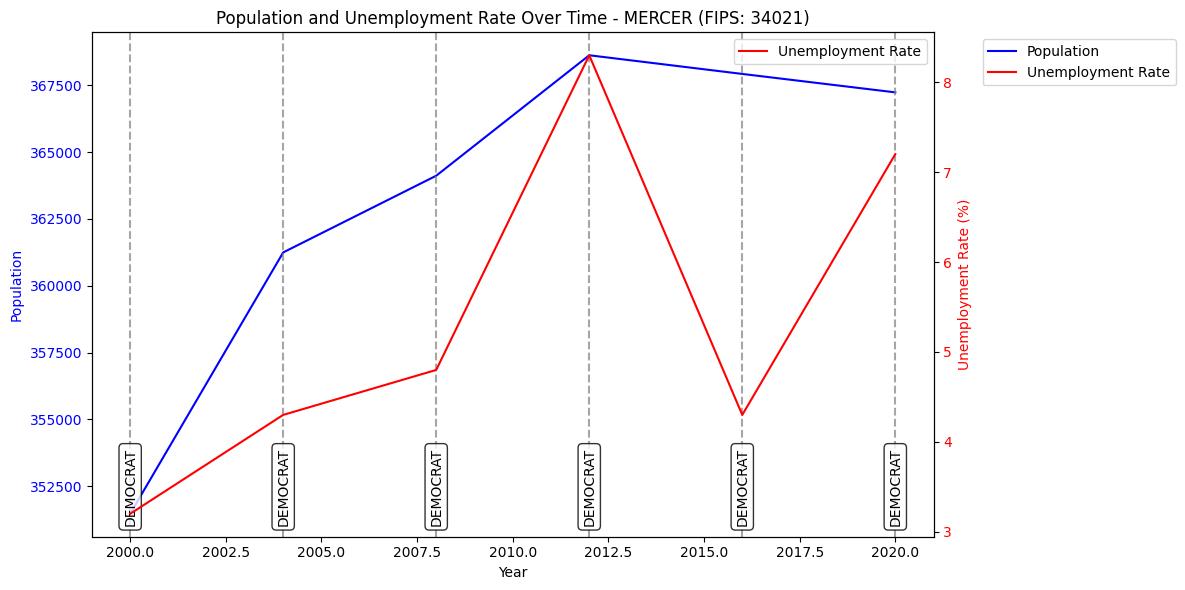

Visualization for MERCER (FIPS Code: 34021)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------
# STEP 1: LOAD YOUR DATA
# ---------------------------------------

# Replace with your actual file paths
# election_data_cleaned = pd.read_csv('election_data_cleaned.csv')
# unemployment_data_cleaned = pd.read_csv('unemployment_data_cleaned.csv')
# combined_df = pd.read_csv('combined_df.csv')

# For demonstration purposes, let's assume the DataFrames are already loaded
# election_data_cleaned = ...
# unemployment_data_cleaned = ...
# combined_df = ...

# ---------------------------------------
# STEP 2: FORMAT FIPS CODES
# ---------------------------------------

def format_fips(fips):
    try:
        return str(int(fips)).zfill(5)
    except (ValueError, TypeError):
        return None  # or handle as appropriate

# Format 'FIPS' in election_data_cleaned
if 'fips_code' in election_data_cleaned.columns:
    election_data_cleaned['FIPS'] = election_data_cleaned['fips_code'].apply(format_fips)
    election_data_cleaned.drop(columns=['fips_code'], inplace=True)
else:
    raise KeyError("Column 'fips_code' not found in election_data_cleaned DataFrame.")

# Format 'FIPS_Code' in unemployment_data_cleaned
if 'FIPS_Code' in unemployment_data_cleaned.columns:
    unemployment_data_cleaned['FIPS'] = unemployment_data_cleaned['FIPS_Code'].apply(format_fips)
    unemployment_data_cleaned.drop(columns=['FIPS_Code'], inplace=True)
else:
    raise KeyError("Column 'FIPS_Code' not found in unemployment_data_cleaned DataFrame.")

# Format 'FIPS' in combined_df
if 'FIPS' in combined_df.columns:
    combined_df['FIPS'] = combined_df['FIPS'].apply(format_fips)
else:
    raise KeyError("Column 'FIPS' not found in combined_df DataFrame.")

# ---------------------------------------
# STEP 3: HANDLE MISSING FIPS CODES
# ---------------------------------------

# Check for missing FIPS codes
print("Missing FIPS in election_data_cleaned:", election_data_cleaned['FIPS'].isnull().sum())
print("Missing FIPS in unemployment_data_cleaned:", unemployment_data_cleaned['FIPS'].isnull().sum())
print("Missing FIPS in combined_df:", combined_df['FIPS'].isnull().sum())

# Drop rows with missing FIPS codes
election_data_cleaned = election_data_cleaned.dropna(subset=['FIPS'])
unemployment_data_cleaned = unemployment_data_cleaned.dropna(subset=['FIPS'])
combined_df = combined_df.dropna(subset=['FIPS'])

# ---------------------------------------
# STEP 4: TRANSFORM DATA TO LONG FORMAT
# ---------------------------------------

# Prepare Unemployment Data
unemployment_cols = [col for col in unemployment_data_cleaned.columns if 'Unemployment_rate_' in col]

unemployment_long = unemployment_data_cleaned.melt(
    id_vars=['FIPS', 'State', 'Area_Name'],
    value_vars=unemployment_cols,
    var_name='variable',
    value_name='unemployment_rate'
)

unemployment_long['year'] = unemployment_long['variable'].str.extract(r'(\d{4})').astype(int)
unemployment_long = unemployment_long.drop(columns='variable')

# Prepare Population Data
pop_cols = [col for col in combined_df.columns if 'POPESTIMATE' in col]

population_long = combined_df.melt(
    id_vars=['STATE', 'COUNTY', 'STNAME', 'FIPS'],
    value_vars=pop_cols,
    var_name='variable',
    value_name='population'
)

population_long['year'] = population_long['variable'].str.extract(r'(\d{4})').astype(int)
population_long = population_long.drop(columns='variable')

# ---------------------------------------
# STEP 5: MERGE DATAFRAMES
# ---------------------------------------

# Merge elections with unemployment data
merged = pd.merge(
    election_data_cleaned,
    unemployment_long,
    on=['FIPS', 'year'],
    how='inner'
)

# Merge the above with population data
merged = pd.merge(
    merged,
    population_long,
    on=['FIPS', 'year'],
    how='inner'
)

# Verify the merged DataFrame
print("Merged DataFrame shape:", merged.shape)
print(merged.head())

# ---------------------------------------
# STEP 6: DEFINE THE VISUALIZATION FUNCTION
# ---------------------------------------

def visualize_county_data(merged_data, fips_code):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Normalize the FIPS code input to ensure consistency
    fips_code = str(fips_code).zfill(5)
    
    # Filter data for the specified FIPS code
    county_data = merged_data[merged_data['FIPS'] == fips_code]
    
    if county_data.empty:
        print(f"No data found for FIPS code {fips_code}. Please check the input.")
        return
    
    # Get the county name
    if 'county_name' in county_data.columns:
        county_name = county_data['county_name'].iloc[0]
    elif 'Area_Name' in county_data.columns:
        county_name = county_data['Area_Name'].iloc[0]
    else:
        county_name = "Unknown County"
    
    # Aggregate election results by year to determine the winning party
    winners = (
        county_data.loc[county_data.groupby('year')['votes_candidate'].idxmax()]
        [['year', 'party']]
        .rename(columns={'party': 'winning_party'})
    )
    
    # Merge winners back into county_data
    county_data = pd.merge(county_data, winners, on='year', how='left')
    
    # Prepare data for plotting (one row per year)
    county_plot_data = county_data.drop_duplicates(subset=['year'])
    
    # Create the plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot population (left y-axis)
    sns.lineplot(data=county_plot_data, x='year', y='population', ax=ax1, color='blue', label='Population')
    ax1.set_ylabel('Population', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Create second y-axis for unemployment rate
    ax2 = ax1.twinx()
    sns.lineplot(data=county_plot_data, x='year', y='unemployment_rate', ax=ax2, color='red', label='Unemployment Rate')
    ax2.set_ylabel('Unemployment Rate (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Mark election years and winning parties
    election_years = [2000, 2004, 2008, 2012, 2016, 2020]
    for year in election_years:
        party = county_plot_data.loc[county_plot_data['year'] == year, 'winning_party'].values
        if len(party) > 0:
            party = party[0]
        else:
            party = "N/A"
        ax1.axvline(x=year, color='grey', linestyle='--', alpha=0.7)
        # Adjust annotation placement dynamically
        y_pos = ax1.get_ylim()[1] * 0.95  # Slightly below the top of the y-axis range
        ax1.text(
            year,
            y_pos,
            party,
            rotation=90,
            verticalalignment='bottom',
            horizontalalignment='center',
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)  # Add background
        )
    
    # Add a title
    ax1.set_title(f'Population and Unemployment Rate Over Time - {county_name} (FIPS: {fips_code})')
    ax1.set_xlabel('Year')
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1))
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()
    
    # Display county name
    print(f"Visualization for {county_name} (FIPS Code: {fips_code})")

# ---------------------------------------
# STEP 7: EXECUTE THE VISUALIZATION
# ---------------------------------------

# Prompt the user for a FIPS code and visualize
fips_code_input = input("Enter a FIPS code (e.g., '01001' for Autauga County, AL): ").strip()
visualize_county_data(merged, fips_code_input)